## 4.4 WGAN
WGAN（Wasserstein GAN）是对GAN的改进。WGAN使用了一种新的损失函数，称为Wasserstein距离，代替原始GAN中的JS散度和KL散度。这种新的损失函数可以更好地衡量两个概率分布之间的差异，从而提高训练的稳定性和生成器的表现。同时，WGAN还采用了权重剪枝和梯度惩罚等技术来进一步优化模型。

### WGAN对GAN的改进，可归结为以下4点：  
- 判别器最后一层去掉sigmoid
- 生成器和判别器的loss不取log
- 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
- 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp，SGD也行。


In [1]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.image import imread
from torchvision import transforms
from torchvision.utils import save_image

%matplotlib inline

In [2]:
# 设备配置
#torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义一些超参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'wgan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
# Image processing
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../data',train=True,transform=trans,download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,batch_size=batch_size, shuffle=True)

## 判别器
获取数据，导入模块的过程基本与VAE的类似，这里不再展开来说。
定义判别器网络结构，这里使用LeakyReLU作为激活函数，经过两个全连接层，输出一个节点，最后经过Sigmoid输出，用于真假二分类。

In [4]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2,inplace=True),
    nn.Linear(hidden_size, 1))
    ##nn.Sigmoid())

## 生成器
GAN的生成器与VAE的生成器类似，不同的是GAN的输出为nn.tanh，它可以使数据分布在[-1,1]之间。其输入是潜在空间的向量z，输出维度与真图像的维度相同。

In [5]:
# 构建生成器，这个相当于AVE中的解码器 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.BatchNorm1d(hidden_size, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

## 定义损失函数，优化器等

In [6]:
# 把判别器和生成器迁移到GPU上
D = D.to(device)
G = G.to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()

d_optimizer = torch.optim.RMSprop(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=0.0002)

#Clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)


## 训练模型
把判别器与生成器组合成一个完整模型，并对该模型进行训练。

In [7]:
for epoch in range(num_epochs):
    D_loss_list, G_loss_list = [], []
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        outputs_r = D(images)
        #d_loss_real = criterion(outputs_r, real_labels)
        real_score = outputs_r
        
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs_f = D(fake_images)
        #d_loss_fake = criterion(outputs_f, fake_labels)
        fake_score = outputs_f        
     
        # 得到判别器总的损失函数
        #d_loss = d_loss_real + d_loss_fake
        d_loss=-torch.mean(outputs_r) + torch.mean(outputs_f)
        
        D_loss_list.append(d_loss.item())
        
        # 对生成器、判别器的梯度清零        
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        #对判别器的权重进行截取
        for p in D.parameters():    
            p.detach().clamp_(-0.01, 0.01)    
        # Train the generator every n_critic iterations
        if i % 3 == 0:
        
        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        #判别器生成的图片越来越像真图片，故损失函数中
        #的标签改为真图片的标签，即希望生成的假图片，
        #越来越靠近真图片
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
        
        
            #g_loss = criterion(outputs, real_labels)
            g_loss=-torch.mean(outputs)
            G_loss_list.append(g_loss.item())
            # 对生成器、判别器的梯度清零
            #进行反向传播及运行生成器的优化器
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
        
        if (i+1) % 400 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 保存真图片
    if (epoch+1)%10 == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 保存假图片
    if (epoch+1)%10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/200], Step [400/600], d_loss: -0.2860, g_loss: -7.4653, D(x): 7.82, D(G(z)): 7.54
Epoch [1/200], Step [400/600], d_loss: -0.0277, g_loss: -5.8824, D(x): 5.89, D(G(z)): 5.86
Epoch [2/200], Step [400/600], d_loss: -0.0059, g_loss: -2.8584, D(x): 2.93, D(G(z)): 2.92
Epoch [3/200], Step [400/600], d_loss: -0.0993, g_loss: -3.3308, D(x): 3.37, D(G(z)): 3.27
Epoch [4/200], Step [400/600], d_loss: -0.0939, g_loss: -1.1736, D(x): 1.23, D(G(z)): 1.13
Epoch [5/200], Step [400/600], d_loss: -0.1412, g_loss: -0.5827, D(x): 0.77, D(G(z)): 0.63
Epoch [6/200], Step [400/600], d_loss: -0.1064, g_loss: -0.5027, D(x): 0.63, D(G(z)): 0.52
Epoch [7/200], Step [400/600], d_loss: -0.1442, g_loss: -0.5491, D(x): 0.73, D(G(z)): 0.58
Epoch [8/200], Step [400/600], d_loss: -0.1624, g_loss: -0.7888, D(x): 0.93, D(G(z)): 0.77
Epoch [9/200], Step [400/600], d_loss: -0.1510, g_loss: -0.3373, D(x): 0.50, D(G(z)): 0.35
Epoch [10/200], Step [400/600], d_loss: -0.1410, g_loss: -0.5787, D(x): 0.77, D(G(z)): 0.6

Epoch [90/200], Step [400/600], d_loss: -0.0094, g_loss: -0.0359, D(x): 0.05, D(G(z)): 0.04
Epoch [91/200], Step [400/600], d_loss: 0.0066, g_loss: -0.1511, D(x): 0.17, D(G(z)): 0.18
Epoch [92/200], Step [400/600], d_loss: 0.0007, g_loss: -0.1201, D(x): 0.11, D(G(z)): 0.11
Epoch [93/200], Step [400/600], d_loss: -0.0129, g_loss: 0.1193, D(x): -0.11, D(G(z)): -0.12
Epoch [94/200], Step [400/600], d_loss: 0.0131, g_loss: -0.1363, D(x): 0.16, D(G(z)): 0.18
Epoch [95/200], Step [400/600], d_loss: -0.0079, g_loss: 0.2057, D(x): -0.21, D(G(z)): -0.22
Epoch [96/200], Step [400/600], d_loss: -0.0013, g_loss: 0.2920, D(x): -0.28, D(G(z)): -0.28
Epoch [97/200], Step [400/600], d_loss: 0.0003, g_loss: -0.0700, D(x): 0.04, D(G(z)): 0.04
Epoch [98/200], Step [400/600], d_loss: -0.0036, g_loss: -0.0220, D(x): -0.00, D(G(z)): -0.01
Epoch [99/200], Step [400/600], d_loss: 0.0118, g_loss: -0.2903, D(x): 0.30, D(G(z)): 0.31
Epoch [100/200], Step [400/600], d_loss: -0.0013, g_loss: -0.0109, D(x): 0.00, D

Epoch [179/200], Step [400/600], d_loss: -0.0092, g_loss: 0.0431, D(x): -0.01, D(G(z)): -0.02
Epoch [180/200], Step [400/600], d_loss: 0.0021, g_loss: 0.2427, D(x): -0.29, D(G(z)): -0.29
Epoch [181/200], Step [400/600], d_loss: -0.0068, g_loss: -0.2512, D(x): 0.25, D(G(z)): 0.24
Epoch [182/200], Step [400/600], d_loss: -0.0023, g_loss: -0.0303, D(x): 0.02, D(G(z)): 0.02
Epoch [183/200], Step [400/600], d_loss: 0.0047, g_loss: 0.0074, D(x): -0.01, D(G(z)): -0.01
Epoch [184/200], Step [400/600], d_loss: -0.0025, g_loss: 0.2304, D(x): -0.21, D(G(z)): -0.21
Epoch [185/200], Step [400/600], d_loss: 0.0007, g_loss: -0.0116, D(x): 0.03, D(G(z)): 0.03
Epoch [186/200], Step [400/600], d_loss: -0.0058, g_loss: -0.2049, D(x): 0.16, D(G(z)): 0.15
Epoch [187/200], Step [400/600], d_loss: 0.0056, g_loss: -0.1131, D(x): 0.12, D(G(z)): 0.13
Epoch [188/200], Step [400/600], d_loss: 0.0054, g_loss: 0.0180, D(x): 0.01, D(G(z)): 0.01
Epoch [189/200], Step [400/600], d_loss: -0.0024, g_loss: 0.2926, D(x): 

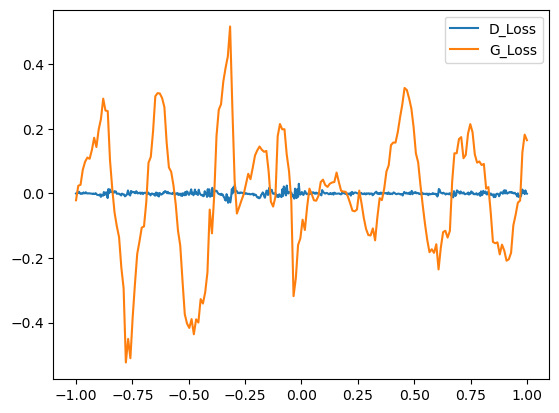

In [8]:
x_axis = np.linspace(-1, 1, len(D_loss_list), endpoint=True)
x_axis1 = np.linspace(-1, 1, len(G_loss_list), endpoint=True)
plt.plot(x_axis, D_loss_list, label='D_Loss')
plt.plot(x_axis1, G_loss_list, label='G_Loss')
plt.legend(loc='best')

In [13]:
len(G_loss_list)

120

## 可视化结果
可视化每次由生成器得到的假图像，即潜在向量z通过生成器得到的图像。

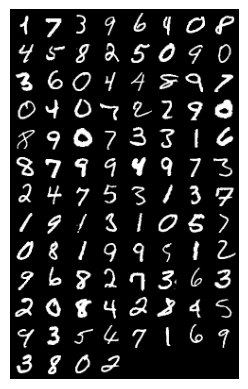

In [9]:
reconsPath = './wgan_samples/real_images.png'
Image = imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

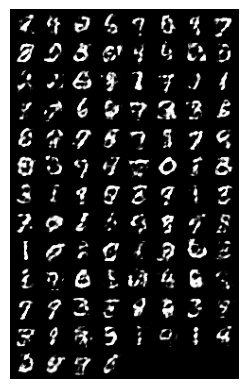

In [11]:
reconsPath = './wgan_samples/fake_images-200.png'
Image = imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()